----

## Identification of Ships from Satellite Imagery

In [1]:
import pandas as pd
import json
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import cv2
import itertools
from itertools import product
from tqdm import tqdm
import folium
import seaborn as sns

from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn import naive_bayes
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, \
    AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
from sklearn import svm
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import sklearn.datasets, sklearn.decomposition

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

/home/conrad/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
# Adjust defaults for seaborn
sns.set_style({'axes.axisbelow': True,
 'axes.edgecolor': 'white',
 'axes.facecolor': '#EAEAF2',
 'axes.grid': False,
 'axes.labelcolor': '.15',
 'axes.linewidth': 0.0,
 'figure.facecolor': (1, 1, 1, 0),
 'font.family': ['sans-serif'],
 'font.sans-serif': ['Arial',
  'Liberation Sans',
  'Bitstream Vera Sans',
  'sans-serif'],
 'grid.color': 'white',
 'grid.linestyle': '-',
 'image.cmap': 'Greys',
 'legend.frameon': False,
 'legend.numpoints': 1,
 'legend.scatterpoints': 1,
 'lines.solid_capstyle': 'round',
 'text.color': '.15',
 'xtick.color': '.15',
 'xtick.direction': 'out',
 'xtick.major.size': 0.0,
 'xtick.minor.size': 0.0,
 'ytick.color': '.15',
 'ytick.direction': 'out',
 'ytick.major.size': 0.0,
 'ytick.minor.size': 0.0})

In [4]:
json = pd.read_json('/home/conrad/Documents/ds/metis/projects/Mcnaulty/ships-in-satellite-imagery/shipsnet.json')

### Explore the dataset

In [5]:
json.head()

,data,labels,locations,scene_ids
0,"[77, 77, 77, 78, 79, 74, 68, 72, 72, 71, 73, 6...",1,"[-122.33766055265983, 37.76632212379826]",20161116_180803_0e14
1,"[81, 83, 84, 83, 82, 84, 83, 80, 83, 83, 84, 8...",1,"[-122.34194895267746, 37.747472669300684]",20170414_180529_0f28
2,"[66, 68, 70, 73, 75, 72, 70, 71, 71, 63, 61, 6...",1,"[-122.34286695330135, 37.716815017729736]",20170328_181231_0e0f
3,"[116, 115, 120, 120, 118, 119, 115, 114, 117, ...",1,"[-122.34701303487154, 37.736955451723546]",20170724_181036_1011
4,"[77, 75, 76, 75, 74, 72, 73, 71, 71, 74, 75, 7...",1,"[-122.33430847708448, 37.74888989075448]",20170703_180945_1009


In [6]:
json.describe()

,labels
count,2000.000000
mean,0.250000
std,0.433121
min,0.000000
25%,0.000000
50%,0.000000
75%,0.250000
max,1.000000


In [7]:
map_osm=folium.Map(location=[37.728523103272465,-122.33766055265983], zoom_start=10)

In [8]:
# Locations of all ship images
locations = json.locations
for i in tqdm(range(500)):
    folium.Marker([locations[i][1],locations[i][0]], popup='ship '+str(i)).add_to(map_osm)

100%|██████████| 500/500 [00:15<00:00, 33.17it/s]


In [9]:
map_osm

### Looking at an example image with various processing techniques

In [10]:
# Function to display images with different image processing techniques applied
def view_features(ex_data_list):
    
    # Displaying the original RGB image
    arr = np.array(ex_data_list).astype('uint8')
    arr.shape
    im = arr.reshape((3, 6400)).T.reshape((80, 80, 3))
    im = Image.fromarray(im)
    im.save('80x80.png')
    plt.imshow(im)
    plt.title('Original RGB Image')
    plt.show()
    
    # Calculation of canny edges and houghlines
    img = cv2.imread('80x80.png', 1)
    edges = cv2.Canny(img, 100, 200)
    lines = cv2.HoughLines(edges, 1, np.pi/600, 1)

    # Selecting two houghlines with highest levels of correlation
    for rho,theta in lines[0]:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        line1 = ((x1, y1), (x2, y2))
        cv2.line(img, (x1, y1), (x2, y2), (0, 0, 255), 1)


    for rho,theta in lines[1]:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        line2 = ((x1, y1), (x2, y2))
        cv2.line(img, (x1, y1), (x2, y2), (0, 0, 255), 1)

    # Displaying the image after canny edge detection
    cv2.imwrite('canny_edges.jpg', img)
    plt.imshow(edges, cmap=plt.get_cmap('gray'), vmin=0, vmax=255)
    plt.title('Canny Edges')
    plt.show()
    
    # Displaying the original image with houghlines overlain
    plt.title('Houghlines')
    plt.imshow(img)
    plt.show()
    
    # Displaying the binarized image
    plt.title('Binarized Image')
    img2 = cv2.imread('80x80.png', 0)
    ret,thresh1 = cv2.threshold(img2, 127, 255, cv2.THRESH_BINARY)
    plt.imshow(thresh1, cmap=plt.get_cmap('gray'), vmin=0, vmax=255)
    plt.show()

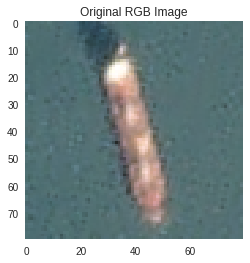

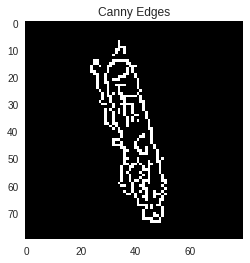

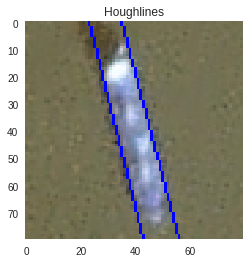

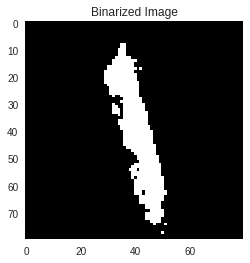

In [11]:
# Example of processed images - ships, as used for feature generation 
view_features(json.data.iloc[7])

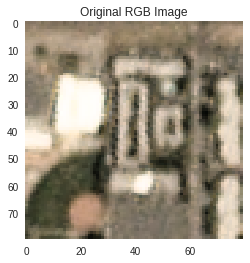

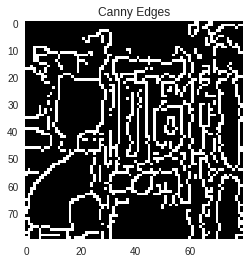

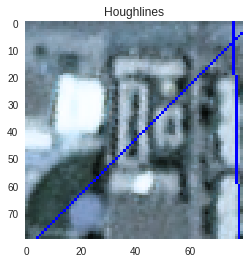

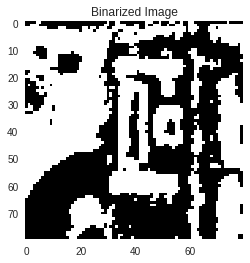

In [12]:
# Example of processed images - not ships, as used for feature generation 
view_features(json.data.iloc[950])

### Feature Extraction

In [13]:
# Function for processing images, and subsequently extracting features from processed images
def shape_feature_w_rho_select(image_data):
    
    # Generate 80x80x3 RGB image from np array
    arr = np.array(image_data).astype('uint8')
    im = arr.reshape((3, 6400)).T.reshape((80, 80, 3))
    im = Image.fromarray(im)
    im.save('80x80.png')
    
    # Taking Canny edges of the image and running HoughLines
    img = cv2.imread('80x80.png', 1)
    edges = cv2.Canny(img, 100, 200)
    lines = cv2.HoughLines(edges, 1, np.pi/1800, 35)
    
    # Take Canny edges ratio white/all pixels
    black, white = np.unique(np.ndarray.flatten(edges), return_counts=True)[1]
    edges_ratio = white / (black + white)
    
    # Binarize image by setting threshold and take binarized while/all pixels ratio
    img2 = cv2.imread('80x80.png', 0)
    ret,thresh = cv2.threshold(img2, 127, 255, cv2.THRESH_BINARY)
    black, white = np.unique(np.ndarray.flatten(thresh), return_counts=True)[1]
    binary_ratio = white / (black + white)
    
    # Take Hu moments
    hu_mom = cv2.HuMoments(cv2.moments(thresh))[0:7].tolist()
    
    if lines is None:
        shape = 0
        return (shape, hu_mom, edges_ratio, binary_ratio)
    
    # Find parallel lines (line1b, line2b) that lay over most canny edges
    for rho,theta in lines[0]:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))
        line1 = ((x1, y1), (x2, y2))
        cv2.line(img, (x1, y1), (x2, y2),(0, 0, 255), 1)
        line1b = [rho,theta]
        
    for rho,theta in lines[1]:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        line2 = ((x1, y1), (x2, y2))
        line2b = [rho,theta]
        cv2.line(img,(x1, y1), (x2, y2),(0, 0, 255), 1)
    
    # If line 2 not created by HoughLines set shape=0
    if line2[0][0] == 0 or line2[1][1] == 0:
        shape = 0
        return (shape, hu_mom, edges_ratio, binary_ratio)
    
    # Find diff in slope theta
    theta_diff = np.abs(line1b[1] - line2b[1])
  
    # If houghlines are parallel within a threshold return shape = 1, otherise shape = 0
    if theta_diff < .03 or (np.abs(theta_diff - np.pi) < .03):
        shape = 1
        return (shape, hu_mom, edges_ratio, binary_ratio)
    elif theta_diff > .03:
        shape = 0
        return (shape, hu_mom, edges_ratio, binary_ratio)
    


In [14]:
# Initialize lists for storage of newly generated features
shape = []
hu_mom = []
binary = []
edg = []
r_ratio = []
g_ratio = []
b_ratio = []
non_accepted = []

# Run feature extraction for all images, find RGB ratios. Run shape_feature_w_rho_select to extract other features
for k in range(2000):   
    image_data = json.data.iloc[k]
    r_sum = sum(json.data.iloc[k][0:6400])
    g_sum = sum(json.data.iloc[k][6400:12800])
    b_sum = sum(json.data.iloc[k][12800:])
    tot_sum = sum(json.data.iloc[k][:])
    r_ratio.append(r_sum / tot_sum)
    g_ratio.append(g_sum / tot_sum)
    b_ratio.append(b_sum / tot_sum)
    
    # Extract other features or return 0 values
    try:
        shapes, hu, edges_ratio, binary_ratio = shape_feature_w_rho_select(image_data)
        edg.append(edges_ratio)
        binary.append(binary_ratio)
        shape.append(shapes)
        hu_mom.append(hu)
    except:
        non_accepted.append(k)
        edg.append(0)
        binary.append(0)
        shape.append(0)
        hu_mom.append([[0], [0], [0], [0], [0], [0], [0]])

# Arrange Hu moments for entry in pandas df
hu_mom2 = []
for i in range(len(hu_mom)):
    int_list = []
    for j in range(len(hu_mom[0])):
        for k in range(len(hu_mom[i][j])):
            int_list.append(hu_mom[i][j][k])
            
    hu_mom2.append(int_list)  

# Add all features to pandas df
edge_ratio_df = pd.DataFrame(edg)
binary_ratio_df = pd.DataFrame(binary)
moment_df = pd.DataFrame(hu_mom2)
parallel_lines = np.array(shape)

# Add parallel_lines, binary ratio, and edge_ratio to pandas df
json['parallel_lines'] = parallel_lines
json2 = pd.merge(json, moment_df, left_index=True, right_index=True)
json2['binary_ratio'] = binary_ratio_df
json2['edge_ratio'] = edge_ratio_df

# Add RGB ratios to pandas df
r_ratio_df = pd.DataFrame(r_ratio)
g_ratio_df = pd.DataFrame(g_ratio)
b_ratio_df = pd.DataFrame(b_ratio)
json2['red_ratio'] = r_ratio_df
json2['green_ratio'] = g_ratio_df
json2['blue_ratio'] = b_ratio_df

# Rename columns associated with HuMoments and replace nan values
json2 = json2.rename(index = str,columns = {0: "HU1", 1: "HU2", 2: "HU3", 3: "HU4", 4: "HU5", 5: "HU6", 6: "HU7"})
json2.binary_ratio.fillna(value=0,inplace=True)
json2.edge_ratio.fillna(value=0,inplace=True)


In [15]:
# Prepare output CSV for tableau 
df_features=json2.loc[:,'parallel_lines':]
df_features['labels'] = json2['labels']
df_features.to_csv('ship_id.csv')

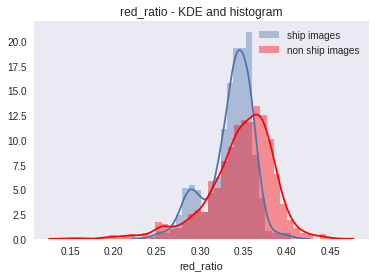

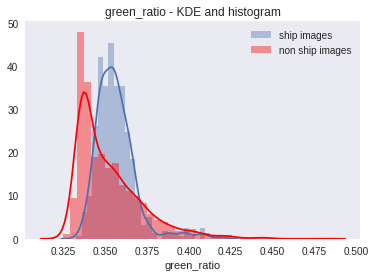

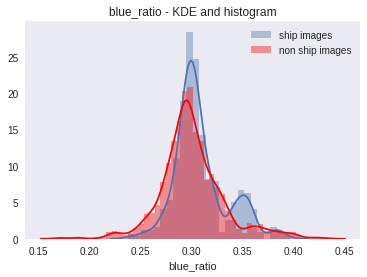

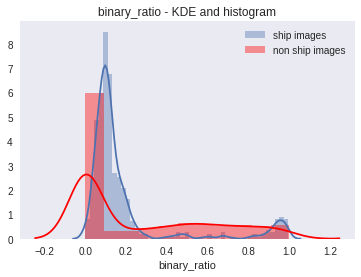

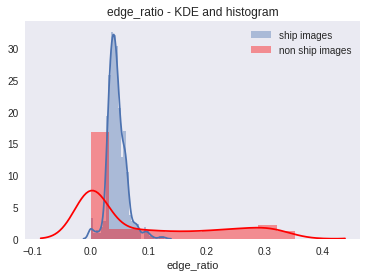

In [16]:
# Display distribution of features from input ratios between images containing ships and images with no ships
feature_list=['red_ratio','green_ratio','blue_ratio','binary_ratio','edge_ratio']
for entry in feature_list:
    ship_features = df_features[entry].iloc[:500]
    non_ship_features = df_features[entry].iloc[500:]
    sns.distplot(ship_features,label='ship images')
    sns.distplot(non_ship_features,color='r',label='non ship images')
    plt.title(entry + ' - KDE and histogram')
    plt.legend()
    plt.show()

### Addition of PCA Features

In [18]:
# Extract raw image values for input to PCA, by using pca_df
pca_df = pd.DataFrame(np.array(json2['data'][0]).reshape(1,19200))
for i in tqdm(range(1,2000)):
    int_df = pd.DataFrame(np.array(json2['data'][i]).reshape(1,19200))
    pca_df = pca_df.append(int_df, ignore_index=True)

100%|██████████| 1999/1999 [01:48<00:00, 18.39it/s]


In [19]:
# Run PCA, only keeping three components
pca = PCA(n_components=3)
pca.fit(pca_df)
pcafeatures_train = pca.transform(pca_df)
pca_features = pd.DataFrame(pcafeatures_train)
pca_features.columns = ['pca1', 'pca2', 'pca3']
pca_features.reset_index(inplace=True)

# Add PCA features to previously generated features
df_features.reset_index(inplace=True)
df_features2 = pd.concat([df_features, pca_features], axis=1)
df_features2.drop(['index'], axis=1, inplace=True)
df_features3 = df_features2.drop(['labels'], axis=1)
df_features3['labels'] = df_features2['labels']

In [20]:
# Generate Xhat, which can be used for displaying images of only PCA componenets used.
pca_np = np.array(pca_df)
mu = np.mean(pca_np, axis=0)
pca = sklearn.decomposition.PCA(n_components=3)
pca.fit(pca_np)
nComp = 3
Xhat = np.dot(pca.transform(pca_np)[:,:nComp], pca.components_[:nComp,:])
Xhat += mu

In [21]:
# Function to display PCA image
def render_pca_features(ex_image):
    # Display original image
    ex_data_list = json2.data.iloc[ex_image]
    arr = np.array(ex_data_list).astype('uint8')
    arr.shape
    im = arr.reshape((3, 6400)).T.reshape((80, 80, 3))
    im = Image.fromarray(im)
    im.save('80x80.png')
    plt.imshow(im)
    plt.title('Original RGB Image')
    plt.show()
    
    # Display rendered image of 3 PCA components
    im = Xhat[ex_image].reshape((3, 6400)).T.reshape((80, 80, 3)).astype('uint8')
    im = Image.fromarray(im)
    plt.title('PCA 3 Components')
    plt.imshow(im)

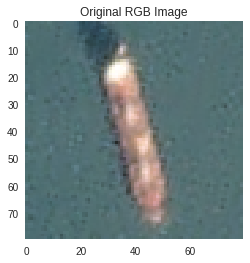

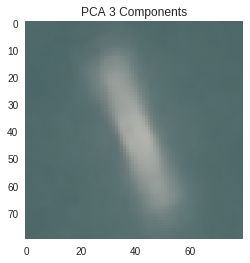

In [22]:
# Original image compared with 3 PCA components for images of ships
render_pca_features(7)

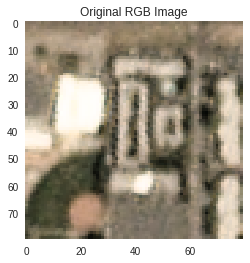

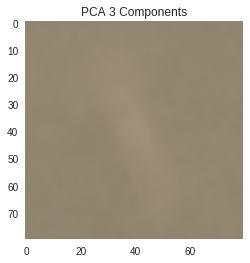

In [23]:
# Original image compared with 3 PCA components for images not containing ships
render_pca_features(950)

### Modeling

In [24]:
def evaluate_model_scaled(model, data, param_grid={}):
    # Split the data into test and train and scale the input features.
    X, y = data[data.columns[:-1]], data[data.columns[-1]]
    xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=48)
    clf = GridSearchCV(model, param_grid, cv=10, scoring='recall')
    scaler = StandardScaler()
    scaler.fit(xtrain)
    xtrain = scaler.transform(xtrain)
    clf.fit(xtrain, ytrain)
    
    # Generate yproba, ypred and cnf and curve_dat for confusion matrix and ROC curve
    ypred = clf.predict(scaler.transform(xtest))
    yproba = clf.predict_proba(scaler.transform(xtest))[:, 1]
    cnf = confusion_matrix(ytest, ypred)
    curve_dat = roc_curve(ytest, yproba)
    
    return clf, cnf, curve_dat, (yproba,scaler.transform(xtest))

### Running top five models

In [25]:
# Running top five performing models
models = {'gbt': GradientBoostingClassifier(),
        'ada': AdaBoostClassifier(),
          'xgbt': XGBClassifier(),
            'edt': ExtraTreesClassifier(),
          'rf': RandomForestClassifier()}
grids = {}
keys = list(models.keys())
curve_dats, confusion_matrices = {}, {}
y_proba_dict={}

for key in keys:
    model = models[key]
    model, conf_mat, curve_dat, yproba = evaluate_model_scaled(model, df_features3, param_grid=grids.get(key, {}))
    models[key] = model
    confusion_matrices[key] = conf_mat
    y_proba_dict[key] = yproba
    curve_dats[key] = curve_dat

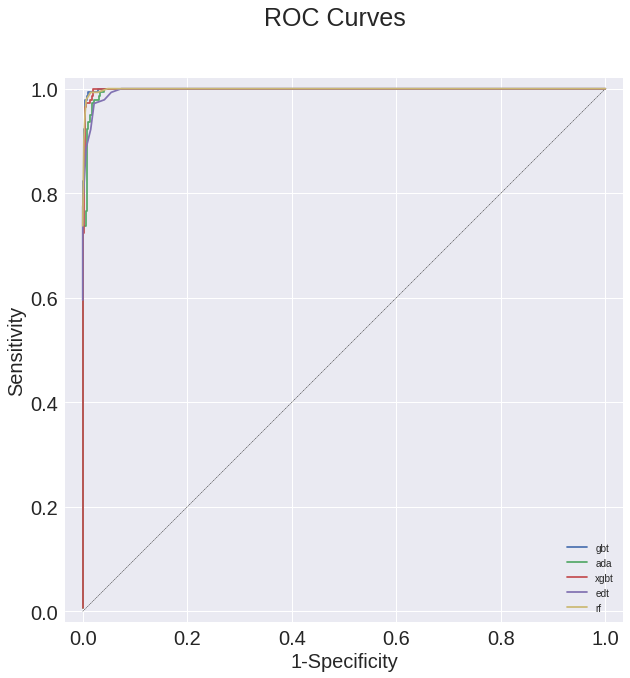

In [26]:
# Plot ROC curves for top 5 performing models
fig, ax = plt.subplots(figsize=(10, 10))
fig.suptitle('ROC Curves', fontsize=25)
ax.plot([0, 1], [0, 1], color='k', linestyle='--', linewidth=.4)

for label, (fpr, tpr, thr) in curve_dats.items():
    ax.plot(fpr, tpr, label=label)
    
ax.axis('equal')
ax.set(xlim=[-.02, 1.02], ylim=[-.02, 1.02])
ax.legend(loc='best')
ax.grid(True)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('1-Specificity', fontsize=20)
plt.ylabel('Sensitivity', fontsize=20)
plt.savefig('ROC_curves_full.png')

In [27]:
# Running top 5 performing models with 200 iterations of random test/train splits to determine best performing model
models = {'ada': AdaBoostClassifier(),
          'xgbt': XGBClassifier(),
            'gbt': GradientBoostingClassifier(),
            'edt': ExtraTreesClassifier(),
          'rf': RandomForestClassifier(),
         }
models_acc_dict = {}

for key, value in models.items():
    for i in range(1,200):
        cnf_list = []
        X, y = df_features3[df_features3.columns[:-1]], df_features3[df_features3.columns[-1]]
        xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3,)
        clf = value
        scaler = StandardScaler()
        scaler.fit(xtrain)
        xtrain = scaler.transform(xtrain)
        clf.fit(xtrain, ytrain)
        ypred = clf.predict(scaler.transform(xtest))
        yproba = clf.predict_proba(scaler.transform(xtest))[:, 1]
        cnf = confusion_matrix(ytest, ypred)
        cnf_list.append(1-(cnf[0][1]+cnf[1][0])/600)
    acc_arr = np.array(cnf_list).mean()
    models_acc_dict[key] = acc_arr

In [28]:
# Accuracy of top 5 performing models over 200 iterations
classes = np.array([0, 1])
models_acc_dict

{'ada': 0.98499999999999999,
 'edt': 0.97333333333333338,
 'gbt': 0.98499999999999999,
 'rf': 0.98333333333333328,
 'xgbt': 0.98499999999999999}

### Settled on Gradient Boosting as best model

In [29]:
# Based on previously step, selected gradient boosting as best performing model
# Running gradient boosting
X, y = df_features3[df_features3.columns[:-1]], df_features3[df_features3.columns[-1]]
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=48)
clf = GradientBoostingClassifier()
scaler = StandardScaler()
scaler.fit(xtrain)
xtrain = scaler.transform(xtrain)
clf.fit(xtrain, ytrain)
ypred = clf.predict(scaler.transform(xtest))
yproba = clf.predict_proba(scaler.transform(xtest))[:, 1]
cnf = confusion_matrix(ytest, ypred)
curve_dat = roc_curve(ytest, yproba)

Confusion matrix, without normalization


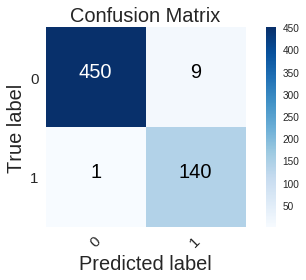

In [30]:
def plot_confusion_matrix_single(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45,fontsize=15)
    plt.yticks(tick_marks, classes,fontsize=15)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",fontsize=20,
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize=20)
    plt.xlabel('Predicted label',fontsize=20)
    plt.title('Confusion Matrix',fontsize=20)

plt.figure()
plot_confusion_matrix_single(cnf, classes=classes)
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

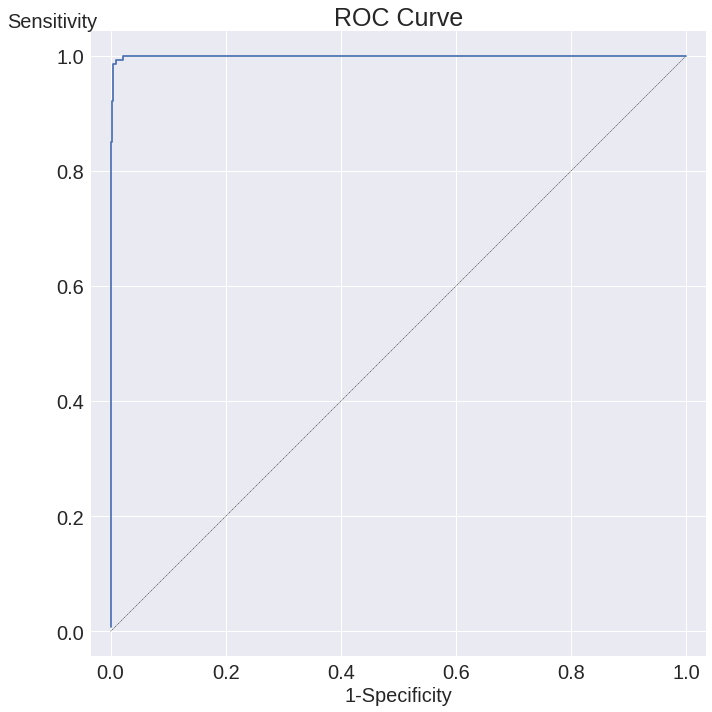

In [31]:
# Plot final ROC curve for gradient boosting only
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot([0, 1], [0, 1], color='k', linestyle='--', linewidth=.4)
fpr=curve_dat[0]
tpr=curve_dat[1]
thr=curve_dat[2]

ax.plot(fpr, tpr)
ax.axis('equal')
ax.set(xlim=[-.02, 1.02], ylim=[-.02, 1.02])
ax.legend(loc='best')
ax.grid(True)

plt.title('ROC Curve',fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('1-Specificity', fontsize=20)
plt.ylabel('Sensitivity',fontsize=20, rotation=0, position=(0,1,0))
plt.tight_layout()
plt.savefig('GB_ROC_curve.png')

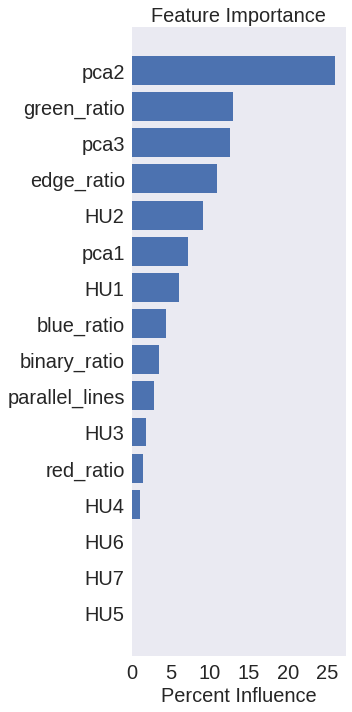

In [32]:
# Display feature importances for gradient boosting model
column_names = df_features3.columns[:-1]
list_column_names=list(column_names)
feature_imp = list(zip(clf.feature_importances_,list_column_names))
feature_imp.sort(key=lambda tup: tup[0], reverse=False)
x= np.arange(1,17)
plt.figure(figsize=(5,10))
prct_imp = [feature_imp[i][0]*100 for i in range(len(feature_imp[:]))]
list_column_names2 = [feature_imp[j][1] for j in range(len(feature_imp[:]))]

# Plot feature importance as percent
plt.barh(x,prct_imp)
plt.yticks(x,list_column_names2,fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Percent Influence',fontsize=20)
plt.title('Feature Importance', fontsize=20)
plt.tight_layout()
plt.savefig('feature_importance.png')